In [40]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from typing import List, Tuple

In [41]:
plt.rcParams['figure.figsize']  = (10, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['xtick.minor.width'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['ytick.minor.width'] = 0

In [42]:
import re

def get_time_and_memory(test_result):
  """Extracts the user time and memory usage from the test result.

  Args:
    test_result: The contents of the test result file.

  Returns:
    A tuple of two floats, representing the user time and memory usage.
  """

  time_match = re.search(r'User time \(seconds\): ([\d.]+)', test_result)
  memory_match = re.search(r'Maximum resident set size \(kbytes\): ([\d.]+)', test_result)

  if time_match and memory_match:
    return float(time_match.group(1)), float(memory_match.group(1))
  else:
    return None, None

In [43]:
# See README in stress_test/context_tests/comparre_to_beautifulsoup/results/ dir for more information on the expected format of the
# result files.
#
# read_results reads all files in a results directory, and returns two lists
# containing, respectively, the times and memory results, already averaged by
# the number of simulations performed.
def read_stress_results(
    result_path,
    min_logs: int = 1,
    max_logs: int = 10_000_000,
    num_simuls: int = 5,
    fromMaximum: bool = False
) -> Tuple[List[float], List[float]]:
    results_dir = f"./results/{result_path}"
    num_logs_ls = np.geomspace(min_logs, max_logs, int(np.log10(max_logs)) + 1).astype(int)

    memory_to_MB: int = 1e6
    time_to_sec: int = 1000
    if(fromMaximum):
        time_to_sec = 1
        memory_to_MB = 1000
    times_agg = []
    memory_agg = []
    for num_logs in num_logs_ls:
        times = []
        memory = []
        for simul_num in range(num_simuls):
            test_result = open(f"{results_dir}/{num_logs}-{simul_num}").read()
            if(fromMaximum):
                t, m = get_time_and_memory(test_result)
                times.append(t)
                memory.append(m)
            else:
                test_result = open(f"{results_dir}/{num_logs}-{simul_num}").read()
                bynewline = test_result.split("\n")
                times.append(int(bynewline[0]))
                memory.append(int(bynewline[1]))
        times_agg.append(np.mean(times) / time_to_sec)
        memory_agg.append(np.mean(memory) / memory_to_MB)
    
    return times_agg, memory_agg

In [44]:
def plot_comparison(
    lists: List[List[float]],
    labels: List[str],
    step: int = 10,
    title: str = None,
    xscale: str = "log",
    yscale: str = "log",
    xlabel: str = "Number of Tokens",
    ylabel: str = "Time (s)",
    min_logs: int = 1,
    max_logs: int = 10_000_000,
    xticks=None,
    yticks=None,
    yticklabels=None,
    legend_loc=None,
    output=None,
) -> None:
    ax = plt.subplot()
    if title is not None:
        ax.set_title(title)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel(xlabel, fontsize = 25)
    ax.set_ylabel(ylabel, fontsize = 25)
    ax.tick_params(axis='x', labelsize=25) 
    ax.tick_params(axis='y', labelsize=25) 
    color_sequence = ["black", "firebrick", "gray", "red"]
    line_sequence = ['-', '-', '-.', '-.']

    if xscale == "log":
        x = np.geomspace(min_logs, max_logs, int(np.log10(max_logs)) + 1).astype(int)
    else:
        x = np.insert(np.linspace(min_logs, max_logs, len(lists[0])), 0, 0)
        for l in lists:
            l.insert(0, 0)
    
    for i in range(len(lists)):
        ax.plot(x, lists[i], label=labels[i], color=color_sequence[i], linewidth = 3, linestyle=line_sequence[i])

    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

    ax.legend(loc=legend_loc)
    if output is not None:
        plt.savefig(output)
    else:
        plt.show()

## Stress tests

In [45]:
lushu_times, lushu_memory = read_stress_results("Lushu")
lushuJVM_times, lushuJVM_memory = read_stress_results("Lushu(JVM)", fromMaximum=True)
beautiful_soup_times, beautiful_soup_memory = read_stress_results("BeautifulSoup", fromMaximum=True)

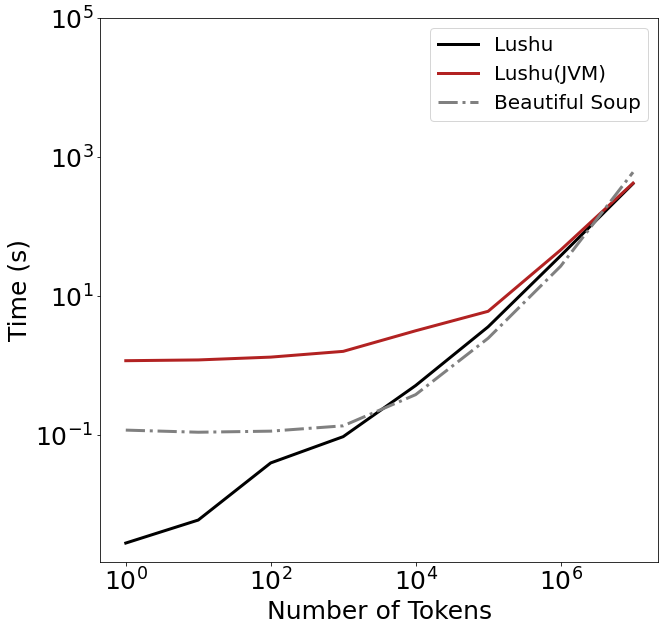

In [46]:
plot_comparison(
    [
        lushu_times,
        lushuJVM_times,
        beautiful_soup_times,
    ],
    [
        "Lushu",
        "Lushu(JVM)",
        "Beautiful Soup"
    ],
    yticks=[0.1, 10, 1000, 100000],
    xticks=[1, 100, 10000, 1000000],
    output="./stress_test/StressTestTimeBS.jpg"
)

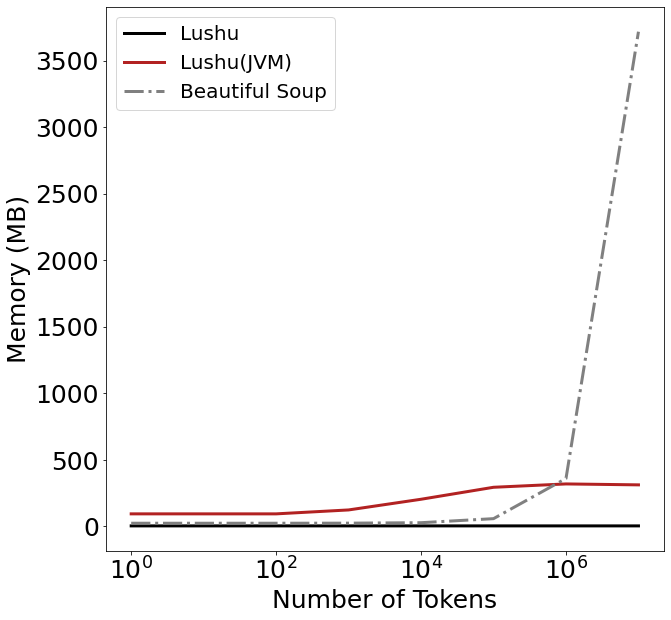

In [47]:
plot_comparison(
    [
        lushu_memory,
        lushuJVM_memory,
        beautiful_soup_memory,
    ],
    [
        "Lushu",
        "Lushu(JVM)",
        "Beautiful Soup",
    ],
    ylabel="Memory (MB)",
    yscale="linear",
    xticks=[1, 100, 10000, 1000000],
    output="./stress_test/StressTestMemoryBS.jpg"
)